$$
\textbf{Lógica Computacional: 2020/2021}\qquad
\textbf{Trabalho 1}\qquad
\scriptsize{Gilberto \, Cunha \quad Tomás \, Carneiro}
$$

# Problema 1

In [1]:
%config InlineBackend.figure_format = "svg"
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from z3 import *

In [2]:
def all_simple_edges(G, source,target):
    paths = list(nx.all_simple_paths(G, source=source, target=target))
    edges = [[(paths[i][j-1], paths[i][j]) for j in range(1, len(paths[i]))] for i in range(len(paths))]
    return edges

Dado um grafo de input $G$ conectado, queremos determinar o seu subgrafo $\mathcal{H}$ com o mesmo número total de vértices $V$ tal que este continue a ser conectado e tenha o menor número de arestas possível.

Ambos $G$ e $\mathcal{H}$ podem ser representados por uma matriz de arestas $A$ e $B$, respetivamente, onde o elemento $A_{ij}, B_{ij} \in \{0, 1\}$ representam a existência de uma aresta orientada do vértice $n_i$ ao vértice $n_j$.

Para cada par de nodos $\langle n_i, n_j \rangle \in G$ existe um conjunto de caminhos simples $S \equiv \{S_k\}$ que os liga. A função "all_simple_paths" da biblioteca "networkx" do python permite determinar este conjunto $S$. Para $\mathcal{H}$ ser fortemente ligado, então deve existir sempre pelo menos um caminho $S_k$ entre estes dois pares.

Para um caminho $S_k$ existir, então:

$$\prod_{\langle n_w, n_z \rangle \in S_k} B_{w, z} \ge 1 $$

- Logo:
$$ \forall_{\langle n_i, n_j \rangle} . n_i \neq n_j \in G, \sum_{S_k \in S} \left( \prod_{\langle n_w, n_z \rangle \in S_k} B_{w, z} \right) \ge 1 $$

- Devemos então minimizar o número de arestas em $\mathcal{H}$:
$$ minimize \sum_{i=0}^{V-1} \sum_{j=0}^{V-1} B_{ij} $$

In [3]:
# Gerar o grafo aleatóriamente
n = 15
k = np.random.randint(2, 5)
p = np.random.random()
G_in = nx.connected_watts_strogatz_graph(n, 2, p)

# Tornar o grafo orientado
G_in = G_in.to_directed()

In [4]:
def strongly_connected_subgraph(G_input):
    solver = Optimize()
    A = {(i, j): Int(f'{i},{j}') for i in range(len(G_input.nodes())) for j in range(len(G_input.nodes()))}
    
    # Pertence ao grafo original
    for i in range(len(G_input.nodes())):
        for j in range(len(G_input.nodes())):
            if (i,j) in G_input.edges:
                g_ij = 1
            else:
                g_ij = 0
            solver.add(A[i,j]>=0, A[i,j]<=g_ij)

    # Condição de ser fortemente conectado
    for i in range(len(G_input.nodes())):
        for j in range(len(G_input.nodes())):
            if i != j:
                S = all_simple_edges(G_input, i, j)
                soma = Sum([Product([A[w,z] for (w,z) in S_k]) for S_k in S])
                solver.add(soma >= 1)

    # Minimizar o número de arestas
    obj = solver.minimize(Sum([A[i,j] for i in range(len(G_input.nodes())) for j in range(len(G_input.nodes()))]))

    # Verificar a satisfazibilidade
    if solver.check() == sat:
        print ("The model is satisfiable")
        print ("Is the minimum amount of edges an integer?", is_int_value(solver.lower(obj)))
        print ("The maximum number of removable edges is", len(G_in.edges) - int(str(solver.lower(obj))))
        m = solver.model()
    else:
        print ("The model is not satisfiable")
        m = None
        
    return m

In [5]:
G, m = nx.DiGraph(), strongly_connected_subgraph(G_in)
G.add_nodes_from([int(str(s).split(",")[0]) for s in m])
G.add_edges_from([(int(str(s).split(",")[0]), int(str(s).split(",")[1])) for s in m if m[s]==1])

The model is satisfiable
Is the minimum amount of edges an integer? True
The maximum number of removable edges is 7


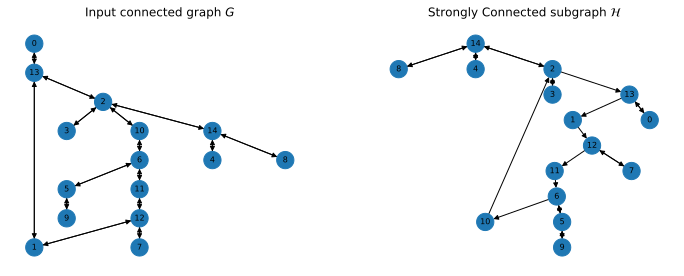

In [14]:
f = plt.figure(figsize=(12, 10))

# Plot do grafo de input
f.add_subplot(221)
plt.title("Input connected graph $G$")
pos = nx.nx_pydot.graphviz_layout(G_in)
pos = nx.nx_pydot.graphviz_layout(G_in, prog="dot")
nx.draw(G_in, font_size=8, pos=pos, with_labels=True)

# Plot do grafo original
f.add_subplot(222)
plt.title("Strongly Connected subgraph $\mathcal{H}$")
pos = nx.nx_pydot.graphviz_layout(G)
pos = nx.nx_pydot.graphviz_layout(G, prog="dot")
nx.draw(G, font_size=8, pos=pos, with_labels=True)

plt.savefig("four_grids.png")
plt.show()

Para um caminho $S_k$ existir, então:
$$\left \lceil \frac{1}{|S_k|} \sum_{\langle n_w, n_z \rangle \in S_k} A_{w, z} \right \rceil \ge 1 $$

Logo:
$$ \forall_{\langle n_i, n_j \rangle} . \langle n_i, n_j \rangle \in G, \sum_{S_k \in S} \left \lceil \frac{1}{|S_k|} \sum_{\langle n_w, n_z \rangle \in S_k} A_{w, z} \right \rceil \ge 1 $$